In [8]:
import requests
import json
from pathlib import Path
import glob
import time
from pprint import pprint as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
import pathlib

def save_match(match_id, tier_code):
    timeline_file = Path(f'../data/match_timeline/{tier_code}_{match_id}.json')
    info_file = Path(f'../data/match_info/{tier_code}_{match_id}.json')
    if timeline_file.is_file() and info_file.is_file():
        print('Match data already exist', end = '\r')
    else:  
        tl_request = f"https://kr.api.riotgames.com/lol/match/v4/timelines/by-match/{match_id}?api_key={api_key}"
        info_request = f"https://kr.api.riotgames.com/lol/match/v4/matches/{match_id}?api_key={api_key}"

        tl = requests.get(tl_request)
        mts = requests.get(info_request)
        
        count = 0
        while ('status' in mts.json()) or ('status' in tl.json()):
            for _ in range(10):
                print(f"Waiting {count+1}", end = "\r")
                count = count + 1
                time.sleep(1)
            tl = requests.get(tl_request)
            mts = requests.get(info_request)
        
        pathlib.Path(f'../data/match_timeline/{tier_code}_{match_id}.json').write_bytes(tl.content)
        pathlib.Path(f'../data/match_info/{tier_code}_{match_id}.json').write_bytes(mts.content)
        print(f"{match_id} Saved", end = '\r')
        
def jg_pts_extracter(match_id, summoner_name):
    timeline_path = f'../data/match_timeline/{match_id}.json'
    info_path = f'../data/match_info/{match_id}.json'
    tl = Path(timeline_path).read_bytes()
    tl_dic = json.loads(tl.decode())
    info = Path(info_path).read_bytes()
    info_dic = json.loads(info.decode())
    
    ingameId = 0
    team = None
    for pId, parts in enumerate(info_dic['participants']):
        if((parts['spell1Id'] == 11 or parts['spell2Id'] == 11) and info_dic['participantIdentities'][pId]['player']['summonerName'] == summoner_name):
            ingameId = pId + 1
            team = 'blue' if parts['teamId'] == 100 else 'red'
            #print(f"{parts['spell1Id'] == 11 or parts['spell2Id'] == 11}/{info_dic['participantIdentities'][pId]['player']['summonerName']}")
            break
            
    x = []
    y = []
    count = 0
    if ingameId != 0:
        for frame in tl_dic['frames']:
            if count > 10:
                break
            if count != 0:
                tmp_x = []
                tmp_y = []
                try:
                    tmp_x.append(frame['participantFrames'][str(ingameId)]['position']['x'])
                    tmp_y.append(frame['participantFrames'][str(ingameId)]['position']['y'])
                    for event in frame['events']:
                        if (event['type'] == 'CHAMPION_KILL'):
                            if((event['killerId'] == ingameId) or (event['victimId'] == ingameId) or (ingameId in event['assistingParticipantIds'])):
                                tmp_x.append(event['position']['x'])
                                tmp_y.append(event['position']['y'])
                except:
                    pass
                x.append(tmp_x)
                y.append(tmp_y)
            count += 1
    return x, y, team

def heatmap(x, y, s, bins):
    heatmap, xedge, yedge = np.histogram2d(x, y, range = [[0, 15000], [0, 15000]], bins=bins)    
    heatmap = gaussian_filter(heatmap, sigma=s)
    return heatmap.T

def show_heat_scatter(pts_dict,s, bins = 500, markersize = 2):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    fig = plt.figure(figsize=(5,10))
    extent = [0,15000,0,15000]
    
    axs[0].plot(pts_dict['blue']['x'], pts_dict['blue']['y'], 'b.', markersize=markersize)
    axs[0].set_xlim([0, 15000])
    axs[0].set_ylim([0, 15000])
    axs[0].set_title("Blue team Scatter plot")
    img = plt.imread("./Minimap.png")
    axs[0].imshow(img, zorder=0, extent=extent)

    heat_blue = heatmap(pts_dict['blue']['x'], pts_dict['blue']['y'], s, bins)
    axs[1].imshow(heat_blue, extent = extent, origin='lower', cmap=cm.jet)
    axs[1].set_title("Blue team, Smoothing with  $\sigma$ = %d" % s)
    
    axs[2].plot(pts_dict['red']['x'], pts_dict['red']['y'], 'b.', markersize=markersize)
    axs[2].set_xlim([0, 15000])
    axs[2].set_ylim([0, 15000])
    axs[2].set_title("Red team Scatter plot")
    img = plt.imread("./Minimap.png")
    axs[2].imshow(img, zorder=0, extent=extent)
    
    heat_red = heatmap(pts_dict['red']['x'], pts_dict['red']['y'], s, bins)
    axs[3].imshow(heat_red, extent = extent, origin='lower', cmap=cm.jet)
    axs[3].set_title("red team, Smoothing with  $\sigma$ = %d" % s)
    plt.show()

def sort_pts_by_time(pts_list):
    pts = []
    frames = 10
    for timelen in range(frames):
        pts.append([])
        for match_num in range((int)(len(pts_list)/frames)):
            pts[timelen] += pts_list[match_num*10 + timelen]
    return pts

def is_Top(x,y):
    return (x < 4000 and y > 10000) and (np.linalg.norm([x-4000,y-10000]) > 2000)

def is_Bottom(x,y):
    return (y < 4000 and x > 10000) and (np.linalg.norm([x-10000,y-4000]) > 2000)

def is_Mid(x,y):
    return np.linalg.norm(([x-7500,y-7500]), ord=1) < 1500

In [12]:
api_key = 'RGAPI-7dc9d2a2-7bab-49fc-8fce-dd74288dbbd6'

summoner_name = "한아리"
tier_code = 4
sum_req = requests.get(f"https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{summoner_name}?api_key={api_key}")
sum_info = sum_req.json()
mat_list_req =requests.get(f"https://kr.api.riotgames.com/lol/match/v4/matchlists/by-account/{sum_info['accountId']}?api_key={api_key}")
mat_req = mat_list_req.json()
mat_list = [match['gameId'] for match in mat_req['matches']]

mts = [f'../data/match_info\\{tier_code}_{mat}.json' for mat in mat_list]

In [13]:
for mat in mat_list:
    save_match(mat, tier_code)

In [14]:
pts = {'blue' : {'x' : [], 'y' : []}, 'red' : {'x' : [], 'y' : []}}
blue_jg_count = 0
red_jg_count = 0
for index in range(len(mts)):
    tmp_x, tmp_y, team = jg_pts_extracter(mts[index][19:-5], summoner_name)
    if team == None:
        continue
    pts[team]['x'] += tmp_x
    pts[team]['y'] += tmp_y
    if team == 'blue':
        blue_jg_count += 1
    else:
        red_jg_count += 1
print(f"{red_jg_count+blue_jg_count} matches ({blue_jg_count} blue / {red_jg_count} red)")

68 matches (29 blue / 39 red)


In [15]:
b_x = sort_pts_by_time(pts['blue']['x'])
b_y = sort_pts_by_time(pts['blue']['y'])
r_x = sort_pts_by_time(pts['red']['x'])
r_y = sort_pts_by_time(pts['red']['y'])

1 minutes
As Blue team
top : 5.71%(2pts)         / mid : 5.71%(2pts)         / bot : 20.00%(7pts)         / other : 68.57%(24pts)         / total : 35pts
As Red team
top : 0.00%(0pts)         / mid : 4.88%(2pts)         / bot : 0.00%(0pts)         / other : 95.12%(39pts)         / total : 41pts


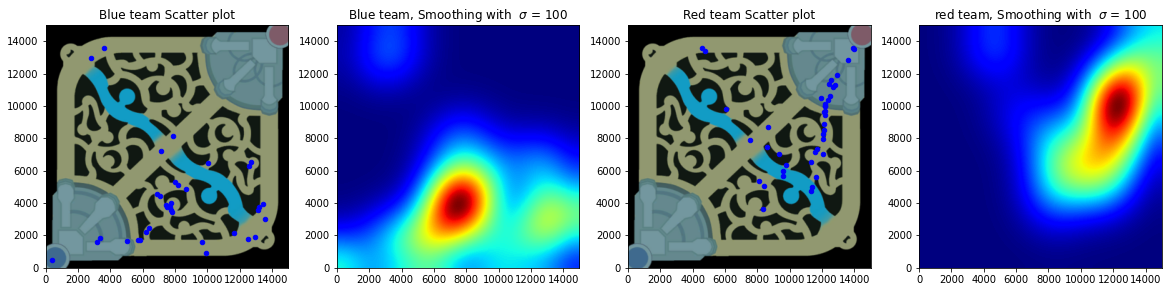

<Figure size 360x720 with 0 Axes>

2 minutes
As Blue team
top : 8.82%(3pts)         / mid : 2.94%(1pts)         / bot : 23.53%(8pts)         / other : 64.71%(22pts)         / total : 34pts
As Red team
top : 5.00%(2pts)         / mid : 10.00%(4pts)         / bot : 12.50%(5pts)         / other : 72.50%(29pts)         / total : 40pts


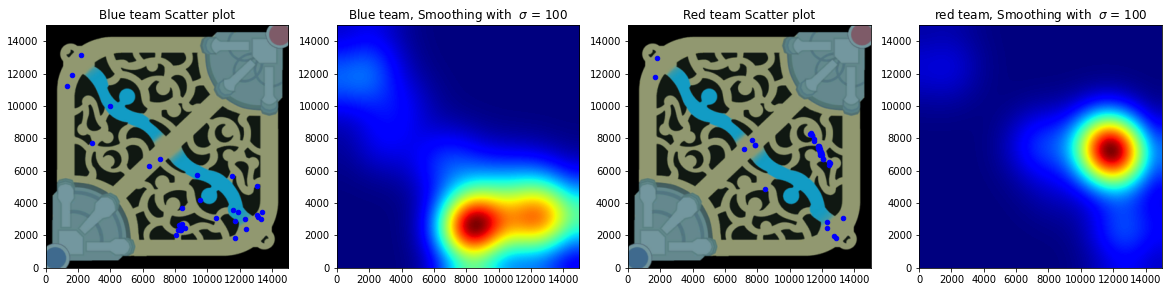

<Figure size 360x720 with 0 Axes>

3 minutes
As Blue team
top : 5.13%(2pts)         / mid : 7.69%(3pts)         / bot : 23.08%(9pts)         / other : 64.10%(25pts)         / total : 39pts
As Red team
top : 4.88%(2pts)         / mid : 7.32%(3pts)         / bot : 9.76%(4pts)         / other : 78.05%(32pts)         / total : 41pts


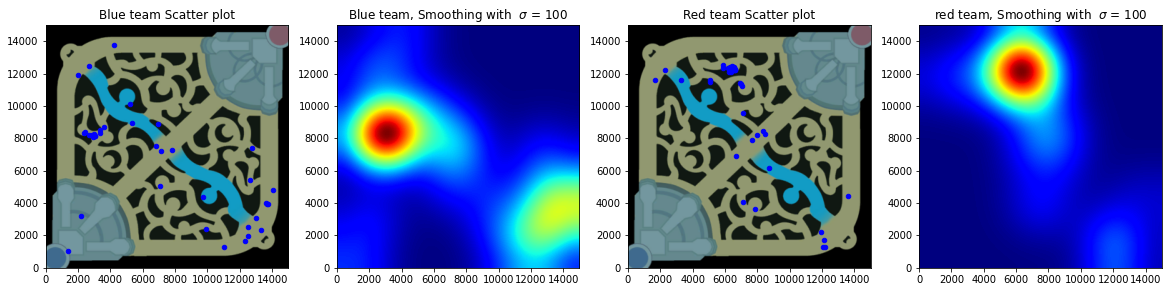

<Figure size 360x720 with 0 Axes>

4 minutes
As Blue team
top : 11.11%(5pts)         / mid : 13.33%(6pts)         / bot : 11.11%(5pts)         / other : 64.44%(29pts)         / total : 45pts
As Red team
top : 26.39%(19pts)         / mid : 5.56%(4pts)         / bot : 6.94%(5pts)         / other : 61.11%(44pts)         / total : 72pts


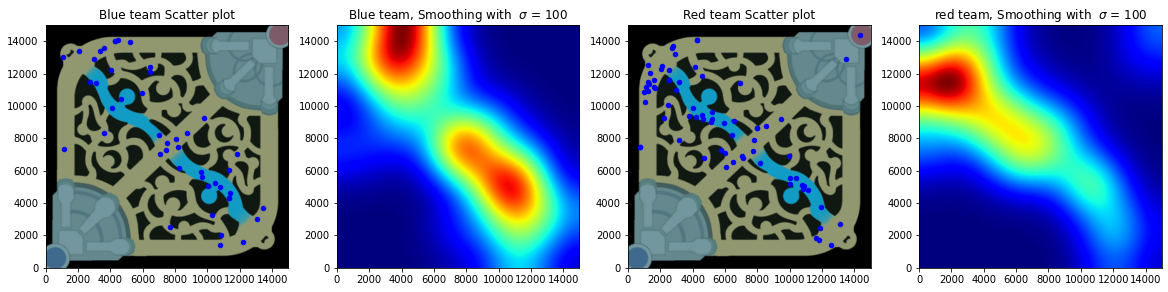

<Figure size 360x720 with 0 Axes>

5 minutes
As Blue team
top : 2.56%(1pts)         / mid : 7.69%(3pts)         / bot : 15.38%(6pts)         / other : 74.36%(29pts)         / total : 39pts
As Red team
top : 8.20%(5pts)         / mid : 8.20%(5pts)         / bot : 13.11%(8pts)         / other : 70.49%(43pts)         / total : 61pts


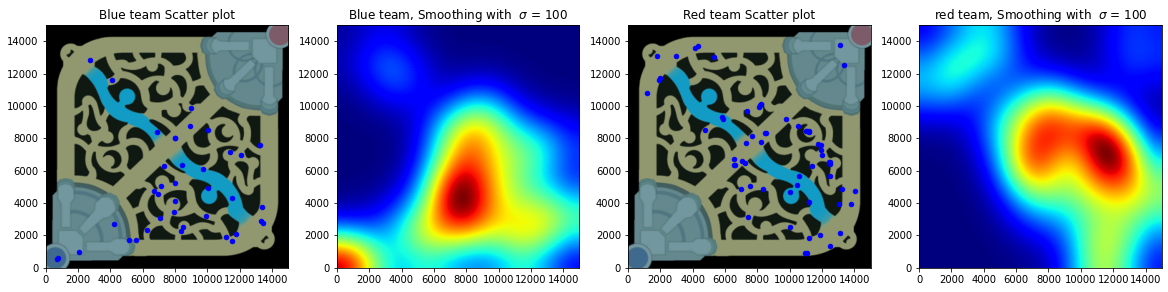

<Figure size 360x720 with 0 Axes>

6 minutes
As Blue team
top : 4.65%(2pts)         / mid : 4.65%(2pts)         / bot : 32.56%(14pts)         / other : 58.14%(25pts)         / total : 43pts
As Red team
top : 9.09%(5pts)         / mid : 23.64%(13pts)         / bot : 16.36%(9pts)         / other : 50.91%(28pts)         / total : 55pts


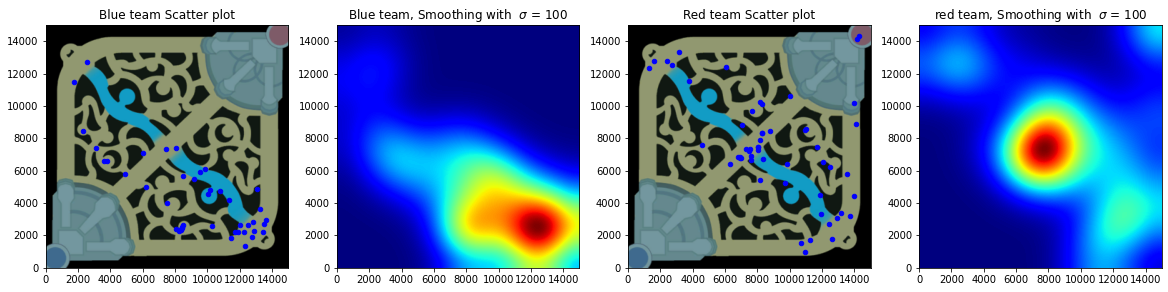

<Figure size 360x720 with 0 Axes>

7 minutes
As Blue team
top : 8.57%(3pts)         / mid : 5.71%(2pts)         / bot : 14.29%(5pts)         / other : 71.43%(25pts)         / total : 35pts
As Red team
top : 4.84%(3pts)         / mid : 14.52%(9pts)         / bot : 19.35%(12pts)         / other : 61.29%(38pts)         / total : 62pts


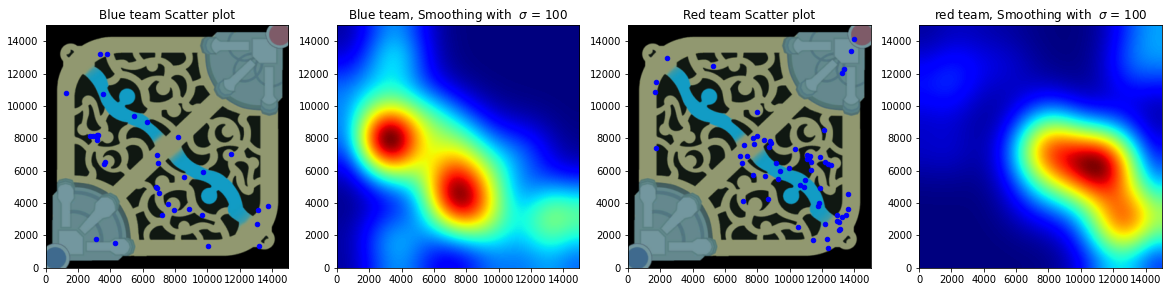

<Figure size 360x720 with 0 Axes>

8 minutes
As Blue team
top : 17.39%(8pts)         / mid : 4.35%(2pts)         / bot : 15.22%(7pts)         / other : 63.04%(29pts)         / total : 46pts
As Red team
top : 2.94%(2pts)         / mid : 10.29%(7pts)         / bot : 25.00%(17pts)         / other : 61.76%(42pts)         / total : 68pts


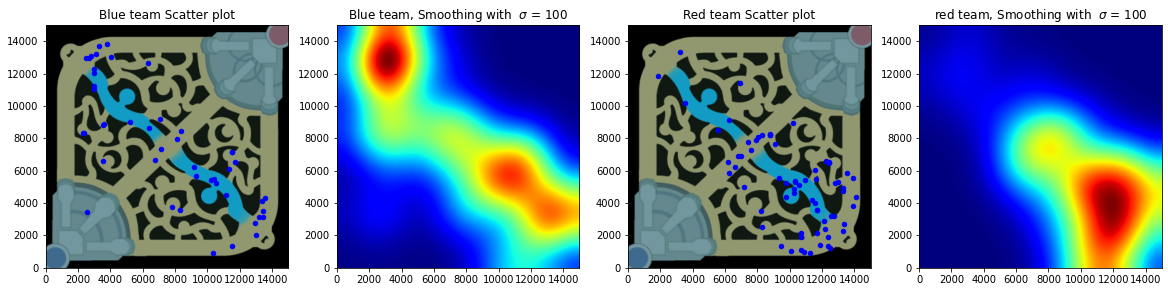

<Figure size 360x720 with 0 Axes>

9 minutes
As Blue team
top : 2.44%(1pts)         / mid : 9.76%(4pts)         / bot : 4.88%(2pts)         / other : 82.93%(34pts)         / total : 41pts
As Red team
top : 8.20%(5pts)         / mid : 11.48%(7pts)         / bot : 18.03%(11pts)         / other : 62.30%(38pts)         / total : 61pts


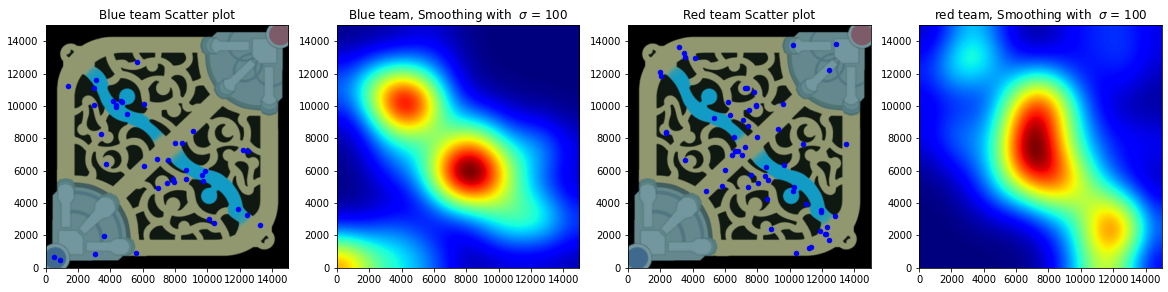

<Figure size 360x720 with 0 Axes>

10 minutes
As Blue team
top : 6.98%(3pts)         / mid : 11.63%(5pts)         / bot : 27.91%(12pts)         / other : 53.49%(23pts)         / total : 43pts
As Red team
top : 6.76%(5pts)         / mid : 18.92%(14pts)         / bot : 16.22%(12pts)         / other : 58.11%(43pts)         / total : 74pts


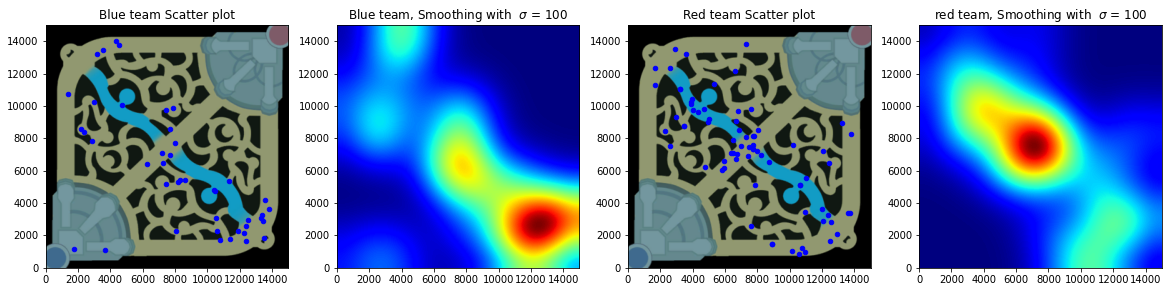

<Figure size 360x720 with 0 Axes>

In [16]:
pts_log = {'blue' : {'top' : [], 'mid' : [], 'bot': [], 'other' : [], 'total' : []},
           'red' : {'top' : [], 'mid' : [], 'bot': [], 'other' : [], 'total' : []}}
for frame in range(10):
    print(f'{frame+1} minutes')
    top_pts = sum(map(is_Top, b_x[frame], b_y[frame]))
    mid_pts = sum(map(is_Mid, b_x[frame], b_y[frame]))
    bot_pts = sum(map(is_Bottom, b_x[frame], b_y[frame]))
    total_pts = len(b_x[frame])
    other_pts = total_pts-top_pts-mid_pts-bot_pts
    pts_log['blue']['top'].append(top_pts)
    pts_log['blue']['mid'].append(mid_pts)
    pts_log['blue']['bot'].append(bot_pts)
    pts_log['blue']['other'].append(other_pts)
    pts_log['blue']['total'].append(total_pts)
    if total_pts == 0:
        print('No Blue team data')
    else:
        print('As Blue team')
        print(f'top : {top_pts/total_pts*100:.2f}%({top_pts}pts) \
        / mid : {mid_pts/total_pts*100:.2f}%({mid_pts}pts) \
        / bot : {bot_pts/total_pts*100:.2f}%({bot_pts}pts) \
        / other : {other_pts/total_pts*100:.2f}%({other_pts}pts) \
        / total : {total_pts}pts')
    top_pts = sum(map(is_Top, r_x[frame], r_y[frame]))
    mid_pts = sum(map(is_Mid, r_x[frame], r_y[frame]))
    bot_pts = sum(map(is_Bottom, r_x[frame], r_y[frame]))
    total_pts = len(r_x[frame])
    other_pts = total_pts-top_pts-mid_pts-bot_pts
    pts_log['red']['top'].append(top_pts)
    pts_log['red']['mid'].append(mid_pts)
    pts_log['red']['bot'].append(bot_pts)
    pts_log['red']['other'].append(other_pts)
    pts_log['red']['total'].append(total_pts)
    if total_pts == 0:
        print('No Red team data')
    else:
        print('As Red team')
        print(f'top : {top_pts/total_pts*100:.2f}%({top_pts}pts) \
        / mid : {mid_pts/total_pts*100:.2f}%({mid_pts}pts) \
        / bot : {bot_pts/total_pts*100:.2f}%({bot_pts}pts) \
        / other : {other_pts/total_pts*100:.2f}%({other_pts}pts) \
        / total : {total_pts}pts')
    show_heat_scatter({'blue' : {'x' : b_x[frame], 'y' : b_y[frame]}, 'red' : {'x' : r_x[frame], 'y' : r_y[frame]}},100,1000, markersize=9)

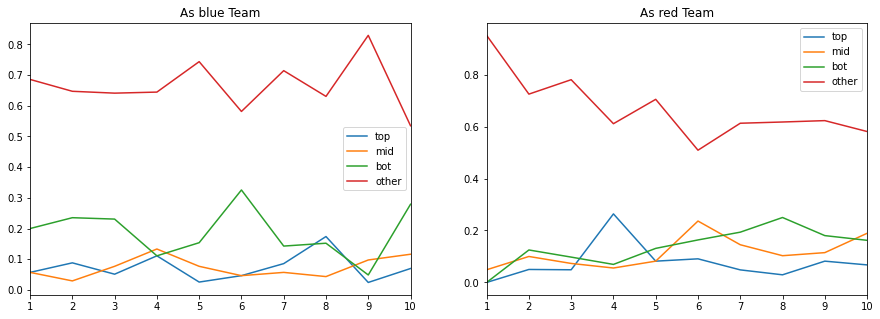

<Figure size 360x720 with 0 Axes>

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig = plt .figure(figsize=(5,10))
x_axis = range(1,11)

for idx, team in enumerate(['blue','red']):
    for lane in ['top','mid','bot','other']:
        axs[idx].plot(x_axis,[pts/total for pts, total in zip(pts_log[team][lane], pts_log[team]['total'])], label = lane)
    axs[idx].set_xlim([1,10])
    axs[idx].legend()
    axs[idx].set_title(f"As {team} Team")
plt.show()